# 02_analysis

# NFL Game Totals Analysis

## Overview

- This notebook uses the nfl_totals_latest file
- Performs the analysis after the the processed data from the previous notebook is appeneded to the nfl_total_latest file.
- Examines relationships between team statistics, betting odds, and game outcomes.
## Input File
- nfl_totals_latest.csv

In [86]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

### Load the most recent data file from the current directory.

In [89]:
def load_existing_data():
    try:
        # Check for most recent file
        import glob
        existing_files = glob.glob('nfl_totals_*.csv')
        if existing_files:
            latest_file = max(existing_files)
            print(f"Loading existing data from {latest_file}")
            df = pd.read_csv(latest_file, encoding='utf-8')
            
            # Convert timestamps
            df['commence_time'] = pd.to_datetime(df['commence_time'])
            df['bookmaker_last_update'] = pd.to_datetime(df['bookmaker_last_update'])
            
            return df
            
        print("No existing totals file found.")
        return None
        
    except Exception as e:
        print(f"Error loading existing data: {str(e)}")
        return None

### Load and prepare data for analysis

In [92]:
def prepare_data_for_analysis():
    df = load_existing_data()
    
    if df is None:
        raise ValueError("No data file found")
    
    # Create completed games dataset
    df_completed = df[df['actual_total'].notna()].copy()
    
    # Convert numeric columns
    numeric_cols = ['home_offense_rank', 'home_points_for', 'home_defense_rank', 
                   'home_points_against', 'away_offense_rank', 'away_points_for', 
                   'away_defense_rank', 'away_points_against', 'point', 'odds',
                   'actual_total', 'predicted_total']
    
    for col in numeric_cols:
        df_completed[col] = pd.to_numeric(df_completed[col], errors='coerce')
    
    return df_completed

### Research Question 1: Analyze correlation between rankings and actual scores

In [95]:
def analyze_rankings_correlation(df):
    print("\n=== Rankings and Score Analysis ===")
    
    # Calculate combined rankings
    df['combined_offense_rank'] = (df['home_offense_rank'] + df['away_offense_rank']) / 2
    df['combined_defense_rank'] = (df['home_defense_rank'] + df['away_defense_rank']) / 2
    
    # Calculate score difference from line
    df['score_diff'] = df['actual_total'] - df['point']
    
    # Calculate correlations
    correlations = {
        'Offense Rank vs Actual': stats.pearsonr(df['combined_offense_rank'], df['actual_total']),
        'Defense Rank vs Actual': stats.pearsonr(df['combined_defense_rank'], df['actual_total']),
        'Line vs Actual': stats.pearsonr(df['point'], df['actual_total'])
    }
    
    # Print correlations
    for name, (corr, p_val) in correlations.items():
        print(f"{name} - Correlation: {corr:.3f} (p={p_val:.3f})")
    
    # Calculate accuracy by ranking tier
    df['offense_tier'] = pd.qcut(df['combined_offense_rank'], q=4, 
                                labels=['Top 25%', '25-50%', '50-75%', 'Bottom 25%'])
    
    accuracy_by_tier = df.groupby('offense_tier')['prediction_correct'].agg(['mean', 'count'])
    print("\nPrediction Accuracy by Offensive Tier:")
    print(accuracy_by_tier)
    
    return correlations, accuracy_by_tier

### Research Question 2: Analyze home field advantage impact

In [98]:
def analyze_home_advantage(df):
    print("\n=== Home Field Advantage Analysis ===")
    
    # Calculate home team performance
    df['home_performance'] = df['actual_total'] - df['point']
    
    # Overall home field impact
    home_stats = {
        'avg_home_diff': df['home_performance'].mean(),
        'home_accuracy': df[df['home_performance'] > 0]['prediction_correct'].mean(),
        'overall_accuracy': df['prediction_correct'].mean()
    }
    
    print(f"Average Home Score Difference: {home_stats['avg_home_diff']:.2f}")
    print(f"Prediction Accuracy (Home): {home_stats['home_accuracy']:.2%}")
    print(f"Prediction Accuracy (Overall): {home_stats['overall_accuracy']:.2%}")
    
    # Home advantage by ranking
    home_by_rank = df.groupby('home_offense_rank').agg({
        'home_performance': 'mean',
        'prediction_correct': 'mean'
    }).round(3)
    
    print("\nHome Advantage by Offensive Rank:")
    print(home_by_rank.head())
    
    # Statistical testing
    ttest_result = stats.ttest_1samp(df['home_performance'], 0)
    print(f"\nHome Advantage T-Test: t={ttest_result.statistic:.3f} (p={ttest_result.pvalue:.3f})")
    
    return home_stats, home_by_rank

### Research Question 3: Analyze best predictive features

In [101]:
def analyze_predictive_features(df):
    print("\n=== Predictive Feature Analysis ===")
    
    # Select features for analysis
    features = ['home_offense_rank', 'home_points_for', 'home_defense_rank', 
               'home_points_against', 'away_offense_rank', 'away_points_for',
               'away_defense_rank', 'away_points_against', 'point', 'odds']
    
    X = df[features]
    y = df['actual_total']
    
    # Train model
    model = LinearRegression()
    model.fit(X, y)
    
    # Analyze feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': abs(model.coef_)
    }).sort_values('importance', ascending=False)
    
    print("Feature Importance:")
    print(feature_importance)
    
    # Calculate prediction metrics
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    
    print(f"\nModel Performance:")
    print(f"R² Score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    return feature_importance, {'r2': r2, 'rmse': rmse}

### Create visualizations for all analyses

In [104]:
def create_visualizations(df, results):
    # 1. Rankings Correlation Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='combined_offense_rank', y='actual_total')
    plt.title('Offensive Ranking vs Actual Total Score')
    plt.show()
    
    # 2. Home Field Advantage Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='offense_tier', y='home_performance')
    plt.title('Home Field Advantage by Offensive Tier')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Feature Importance Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results['feature_importance'].head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Predictive Features')
    plt.tight_layout()
    plt.show()

### Main analysis pipeline

Loading existing data from nfl_totals_latest.csv

=== Rankings and Score Analysis ===
Offense Rank vs Actual - Correlation: -0.200 (p=0.000)
Defense Rank vs Actual - Correlation: 0.283 (p=0.000)
Line vs Actual - Correlation: 0.230 (p=0.000)

Prediction Accuracy by Offensive Tier:
                  mean  count
offense_tier                 
Top 25%       0.578035    173
25-50%        0.710227    176
50-75%        0.625000    168
Bottom 25%    0.512346    162

=== Home Field Advantage Analysis ===
Average Home Score Difference: 1.04
Prediction Accuracy (Home): 65.69%
Prediction Accuracy (Overall): 60.82%

Home Advantage by Offensive Rank:
                   home_performance  prediction_correct
home_offense_rank                                      
1                             9.196               0.679
2                            10.028               1.000
3                             6.056               0.222
4                             1.105               0.474
5                   

C:\Users\Ckron\AppData\Local\Temp\ipykernel_25156\1440572735.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_tier = df.groupby('offense_tier')['prediction_correct'].agg(['mean', 'count'])


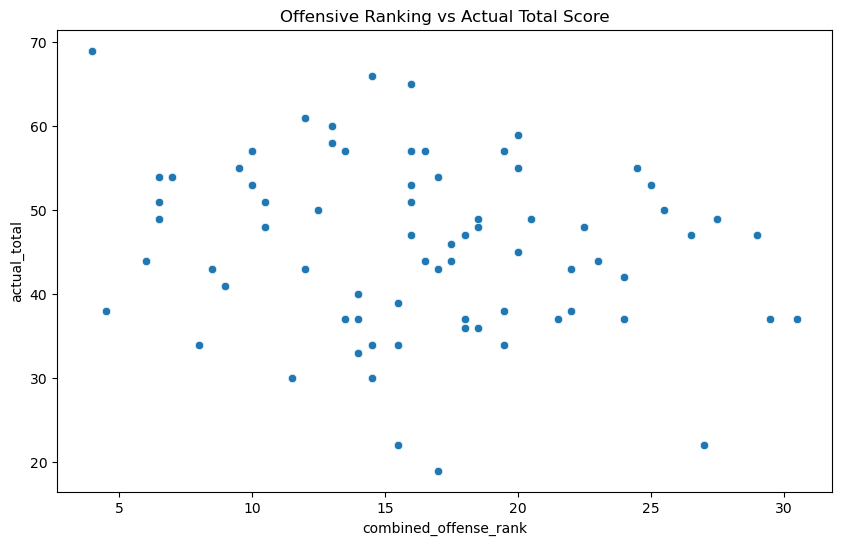

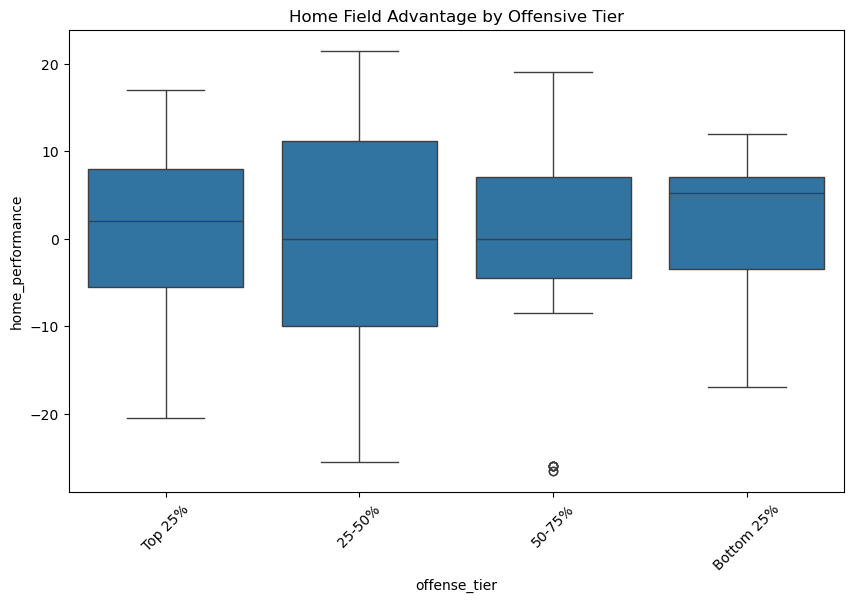

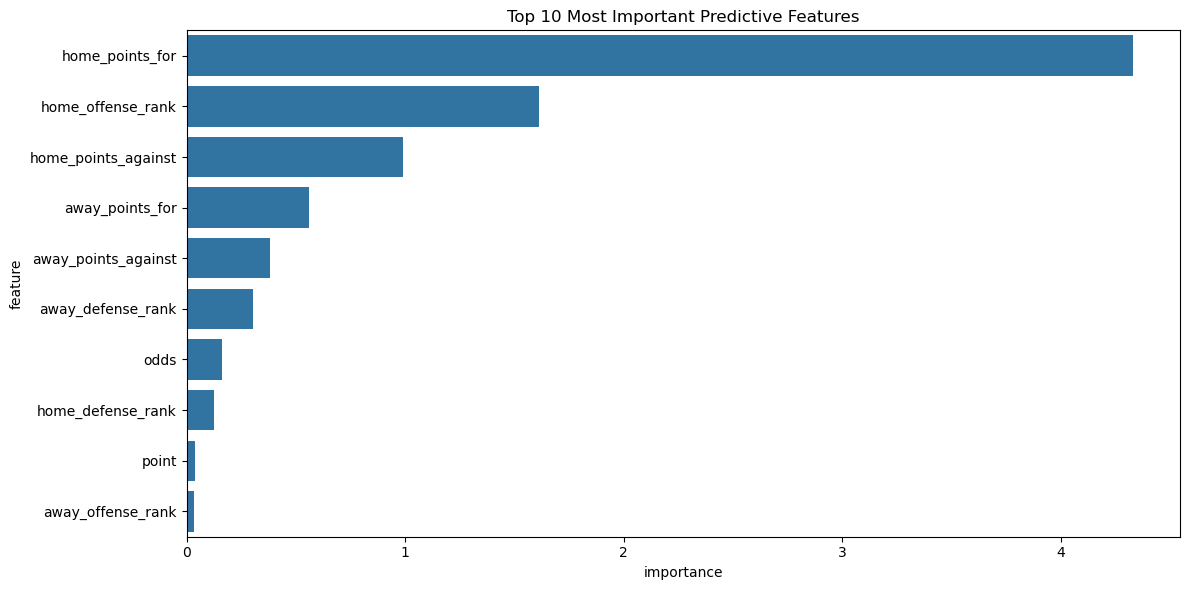

In [116]:
def main():
    # Load and prepare data
    df = prepare_data_for_analysis()
    
    # Run analyses
    ranking_results = analyze_rankings_correlation(df)
    home_advantage_results = analyze_home_advantage(df)
    predictive_results = analyze_predictive_features(df)
    
    # Store results
    results = {
        'ranking_analysis': ranking_results,
        'home_advantage': home_advantage_results,
        'predictive_features': predictive_results,
        'feature_importance': predictive_results[0]
    }
    
    # Create visualizations
    create_visualizations(df, results)
    
    return results

if __name__ == "__main__":
    results = main()